In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

In [ ]:
df = pd.read_csv('catfish.csv')

In [ ]:
df.head()

,Date,Total
0,1986-1-01,9034
1,1986-2-01,9596
2,1986-3-01,10558
3,1986-4-01,9002
4,1986-5-01,9239


In [ ]:
df.isnull().sum()

Date     0
Total    0
dtype: int64

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

start_date = datetime(1996,1,1)
end_date = datetime(2008,1,1)
df = df[(df.index >= start_date) & (df.index <= end_date)]

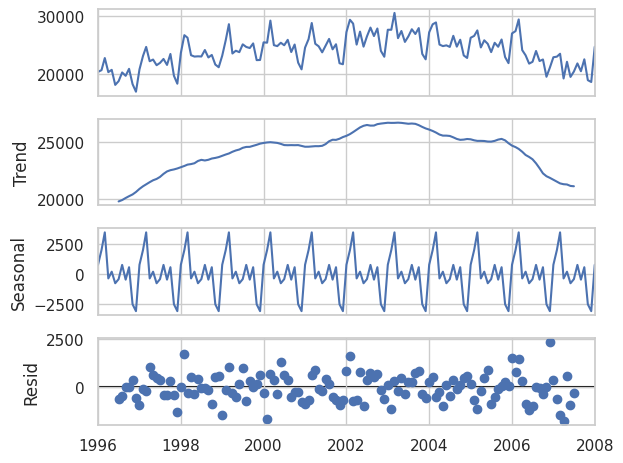

In [ ]:
plt.figsize=(14,6)
result = seasonal_decompose(df,model='additive')
fig = result.plot()

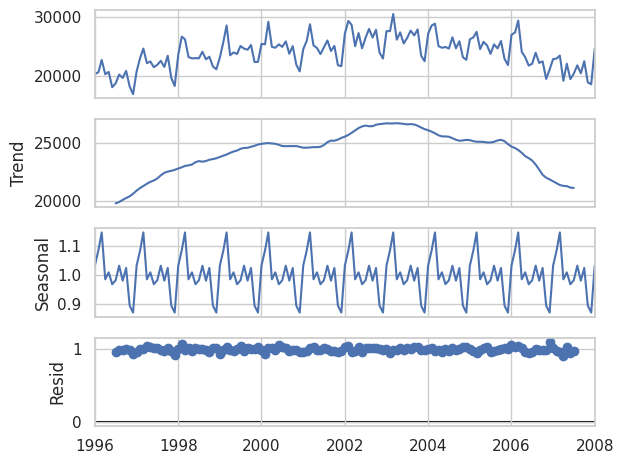

In [ ]:
plt.figsize=(14,6)
result = seasonal_decompose(df,model='multiplicative')
fig = result.plot()

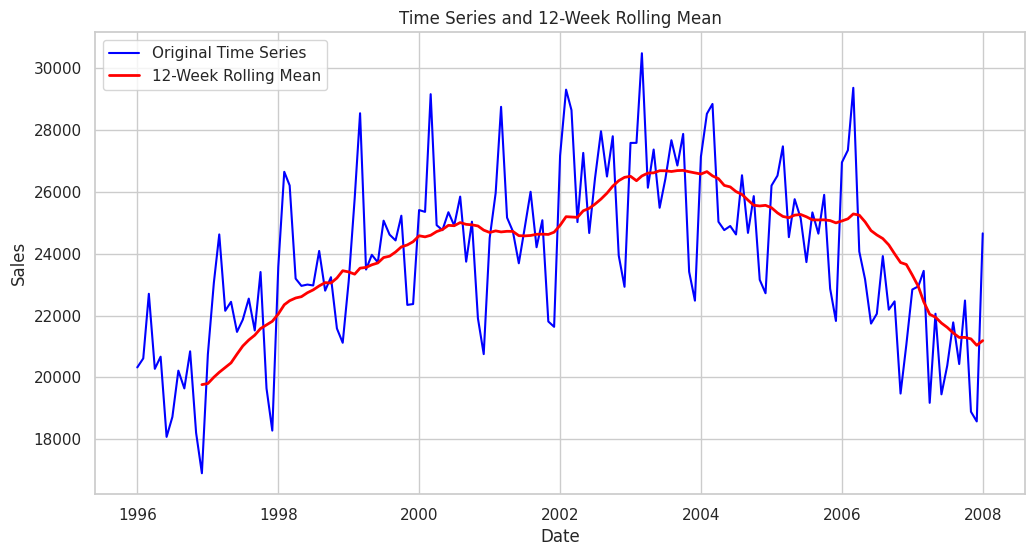

In [ ]:
rolling_mean = df['Total'].rolling(window=12).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['Total'], label='Original Time Series', color='blue')
plt.plot(rolling_mean, label='12-Week Rolling Mean', color='red', linewidth=2)
plt.title('Time Series and 12-Week Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Total'].values)
result

(-1.8796998671338676,
 0.34167036071480034,
 14,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 2222.5244882802926)

Given the ADF statistic, critical values, and p-value, we do not reject the null hypothesis at the 95% confidence level. This implies that there is insufficient evidence to conclude that the time series is stationary, and we accept the null hypothesis that the time series has a unit root, it is non-stationary for 95% confidence:
Critical Value at 5%: -2.870
adf stat: -1.589 > -2.870
p value: 0.488 > 0.05

ADF Statistic: -2.4399126130349664
p-value: 0.13078670002298848
Critical Value (1%): -3.481281802271349
Critical Value (5%): -2.883867891664528
Critical Value (10%): -2.5786771965503177


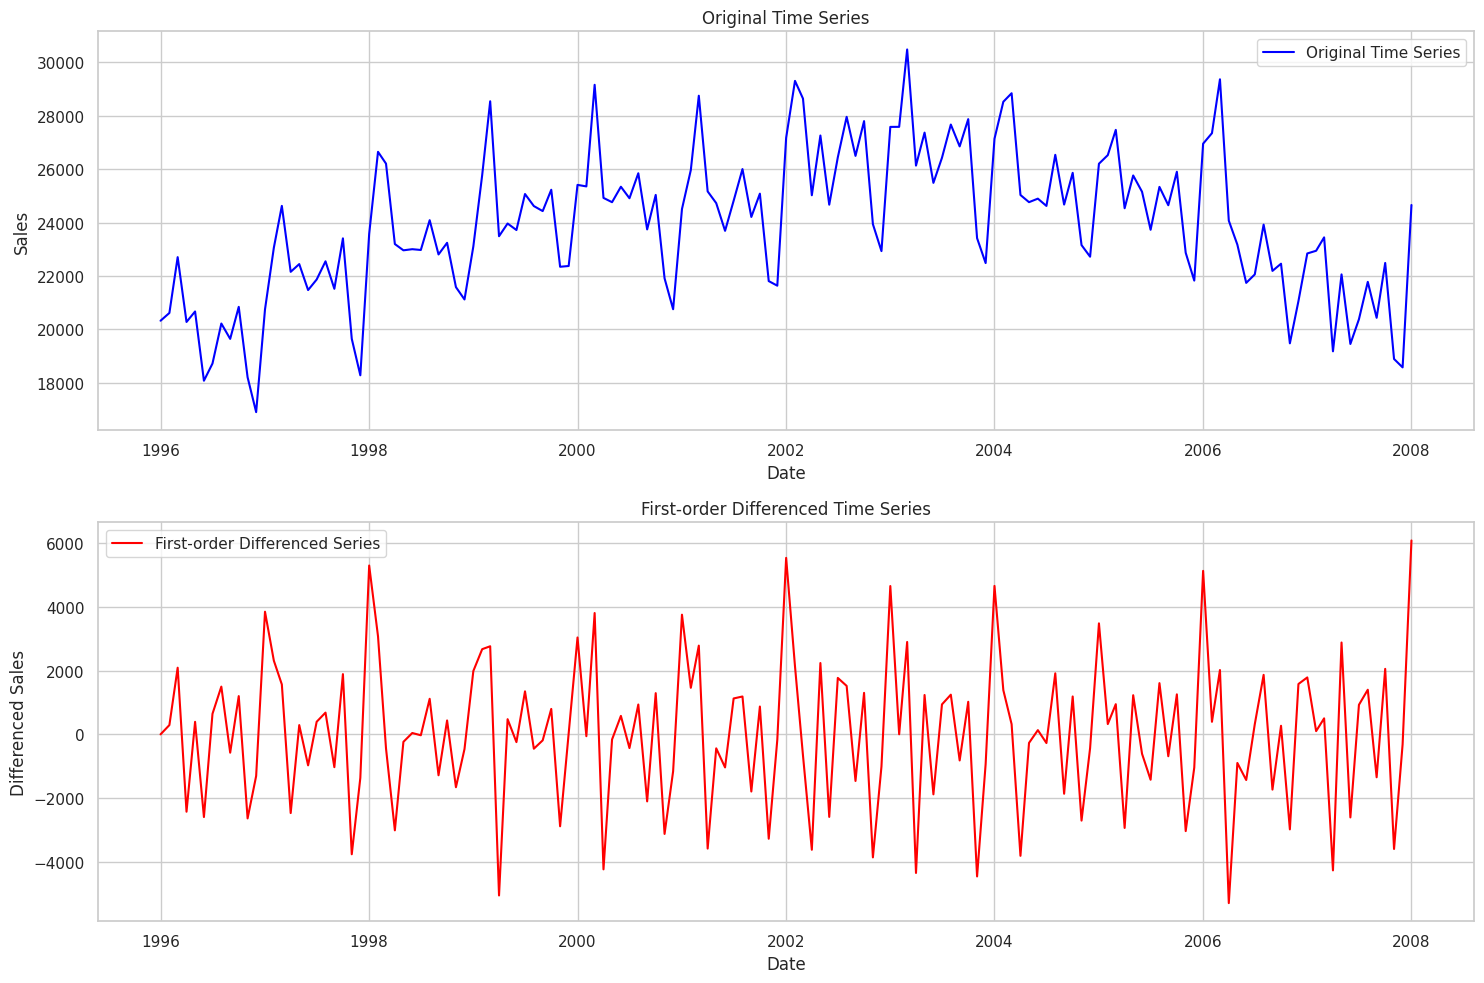

In [ ]:
df['diff'] = df['Total'].diff().fillna(0)

# Perform ADF test and print the result
adf_result = adfuller(df['diff'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
for key, value in adf_result[4].items():
    print(f'Critical Value ({key}): {value}')

# Plot the original series and the differenced series
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

# Original time series plot
ax[0].plot(df['Total'], label='Original Time Series', color='blue')
ax[0].set_title('Original Time Series')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Sales')
ax[0].legend()

# Differenced time series plot
ax[1].plot(df['diff'], label='First-order Differenced Series', color='red')
ax[1].set_title('First-order Differenced Time Series')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Differenced Sales')
ax[1].legend()

plt.tight_layout()
plt.show()

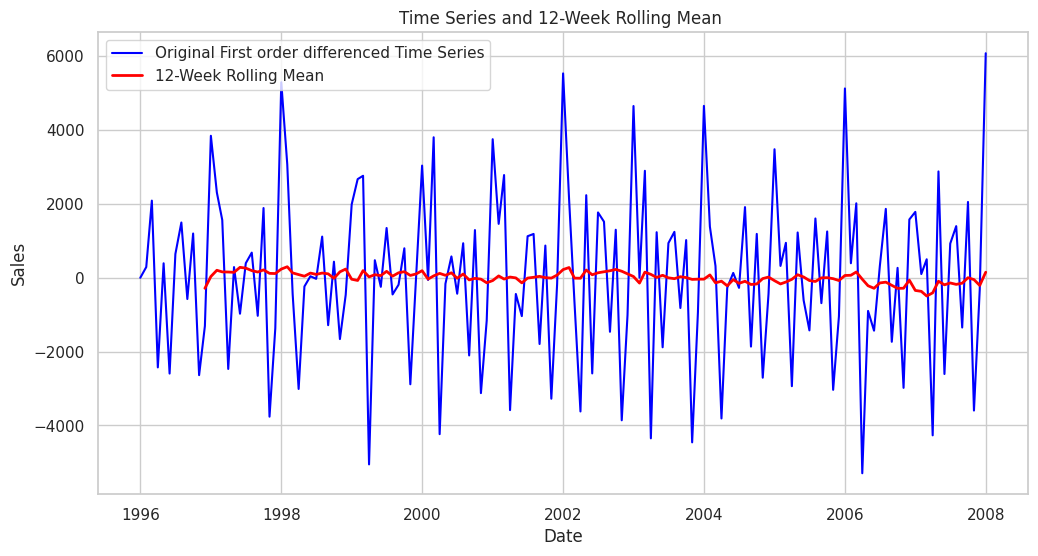

In [ ]:
rolling_mean = df['diff'].rolling(window=12).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['diff'], label='Original First order differenced Time Series', color='blue')
plt.plot(rolling_mean, label='12-Week Rolling Mean', color='red', linewidth=2)
plt.title('Time Series and 12-Week Rolling Mean ')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

ADF Statistic: -2.3279857947310107
p-value: 0.16310077129098116
Critical Value (1%): -3.481281802271349
Critical Value (5%): -2.883867891664528
Critical Value (10%): -2.5786771965503177


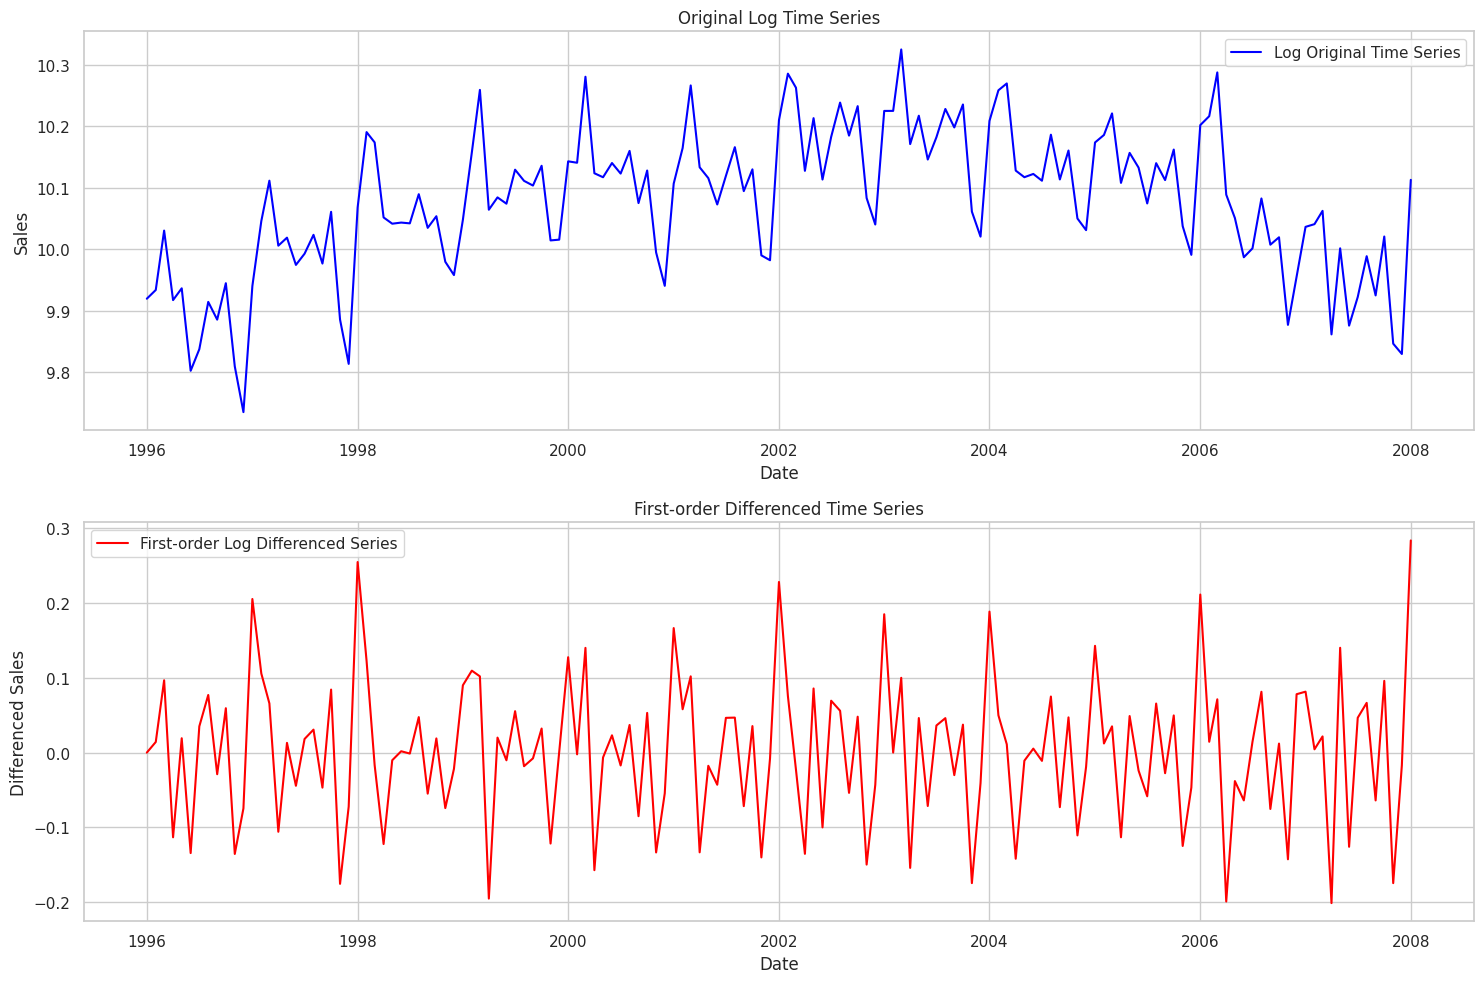

In [ ]:
df['Log'] = np.log(df['Total'])
df['mdiff'] = df['Log'].diff().fillna(0)

adf_result = adfuller(df['mdiff'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
for key, value in adf_result[4].items():
    print(f'Critical Value ({key}): {value}')

# Plot the original series and the differenced series
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

# Original time series plot
ax[0].plot(df['Log'], label='Log Original Time Series', color='blue')
ax[0].set_title('Original Log Time Series')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Sales')
ax[0].legend()

# Differenced time series plot
ax[1].plot(df['mdiff'], label='First-order Log Differenced Series', color='red')
ax[1].set_title('First-order Differenced Time Series')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Differenced Sales')
ax[1].legend()

plt.tight_layout()
plt.show()

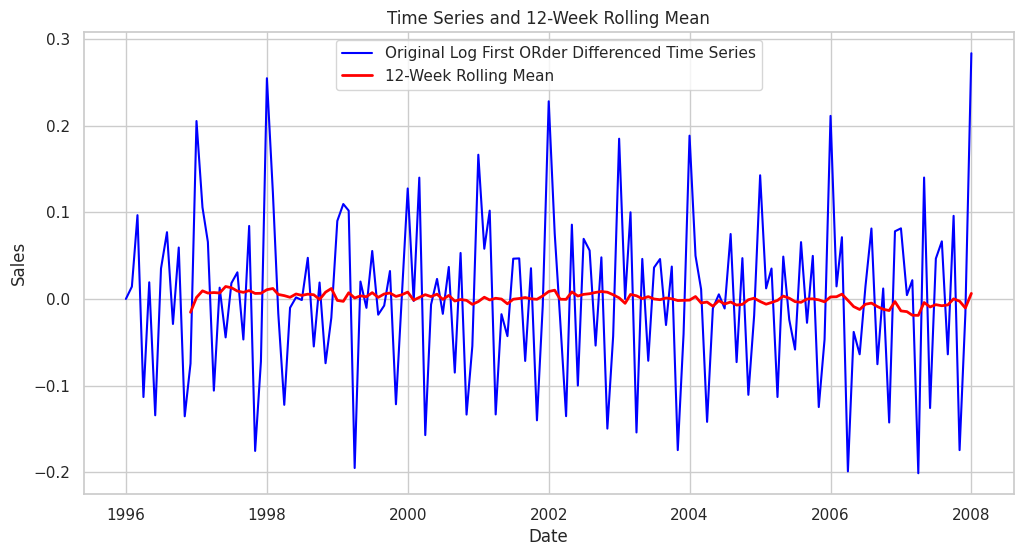

In [ ]:
rolling_mean = df['mdiff'].rolling(window=12).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['mdiff'], label='Original Log First ORder Differenced Time Series', color='blue')
plt.plot(rolling_mean, label='12-Week Rolling Mean', color='red', linewidth=2)
plt.title('Time Series and 12-Week Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

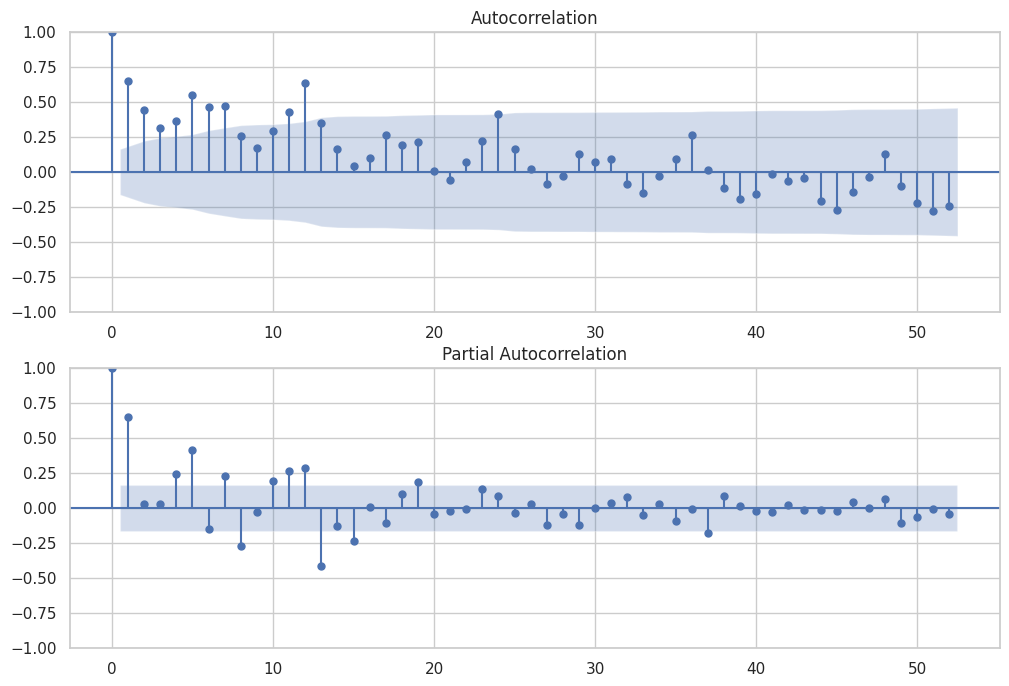

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
plot_acf(df['Total'], lags=52, ax=ax[0])
plot_pacf(df['Total'], lags=52, ax=ax[1])
plt.show()

Step 1 — Check stationarity: If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast. .
Step 2 — Difference: If the time series is not stationary, it needs to be stationarized through differencing. Take the first difference, then check for stationarity. Take as many differences as it takes. Make sure you check seasonal differencing as well.
Step 3 — Filter out a validation sample: This will be used to validate how accurate our model is. Use train test validation split to achieve this
Step 4 — Select AR and MA terms: Use the ACF and PACF to decide whether to include an AR term(s), MA term(s), or both.
Step 5 — Build the model: Build the model and set the number of periods to forecast to N (depends on your needs).

In [ ]:
split =int( 0.8*(len(df)))
y_train = df[:split]
y_valid = df[split:]

model = ARIMA(df['Total'], order=(12,1,12))
model_fit = model.fit()

y_pred = model_fit.predict()

# Calcuate metrics
score_mae = mean_absolute_error(df['Total'], y_pred)
score_rmse = math.sqrt(mean_squared_error(df['Total'], y_pred))

print('RMSE: {}'.format(score_rmse))
print('MAE: {}'.format(score_mae))

RMSE: 2036.6863024772852
MAE: 1022.419248297555


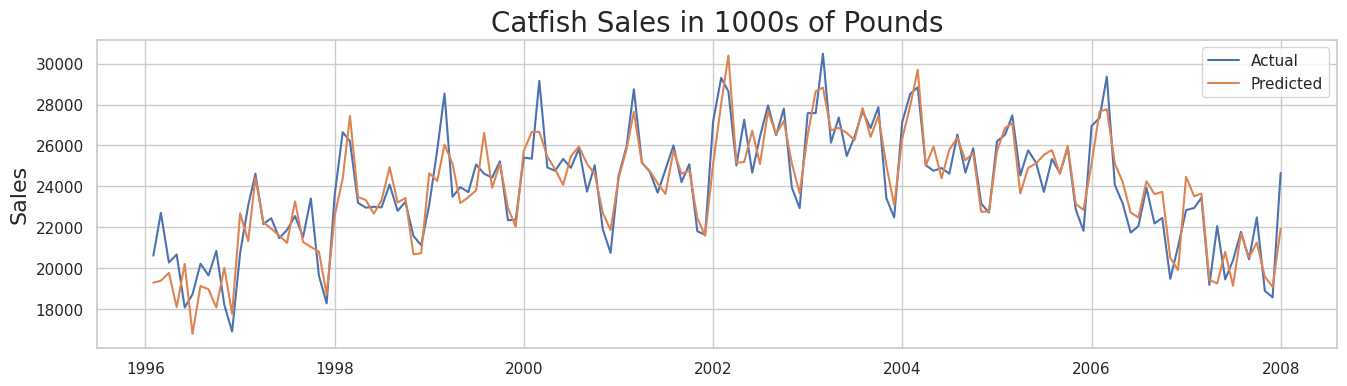

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(df['Total'].iloc[1:], label="Actual")
plt.plot(y_pred.iloc[1:], label="Predicted")
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend()

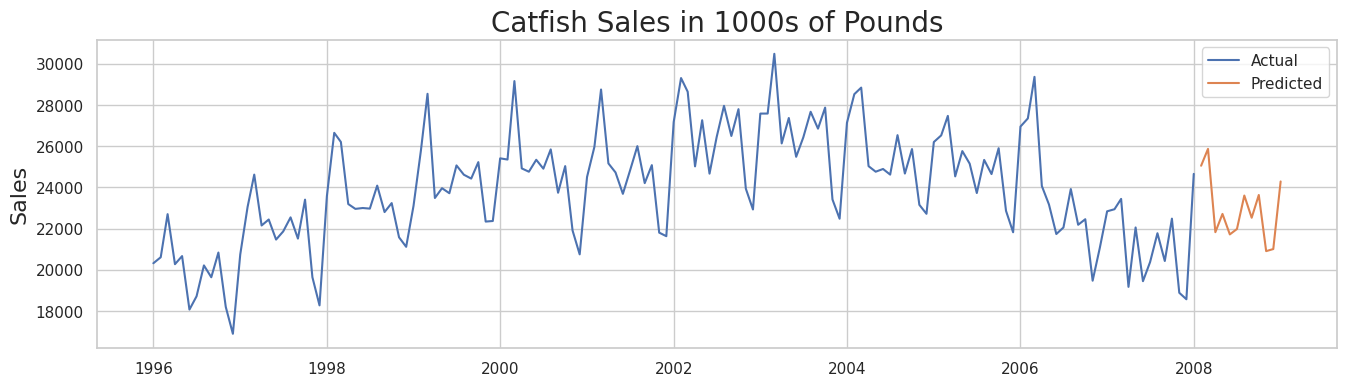

In [ ]:
y_forecast_arima = model_fit.forecast(steps = 12)
plt.figure(figsize=(16,4))
plt.plot(df['Total'], label="Actual")
plt.plot(y_forecast_arima, label="Predicted")
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend()

Sarima

In [ ]:
sarima = SARIMAX(df['Total'],
                order=(1,1,1),
                seasonal_order=(1,1,0,12))
predictions = sarima.fit().predict()

In [ ]:
score_mae1 = mean_absolute_error(df['Total'], predictions)
score_rmse1 = math.sqrt(mean_squared_error(df['Total'], predictions))

print('RMSE: {}'.format(score_rmse1))
print('MAE: {}'.format(score_mae1))

RMSE: 2175.938358817673
MAE: 1110.612343235054


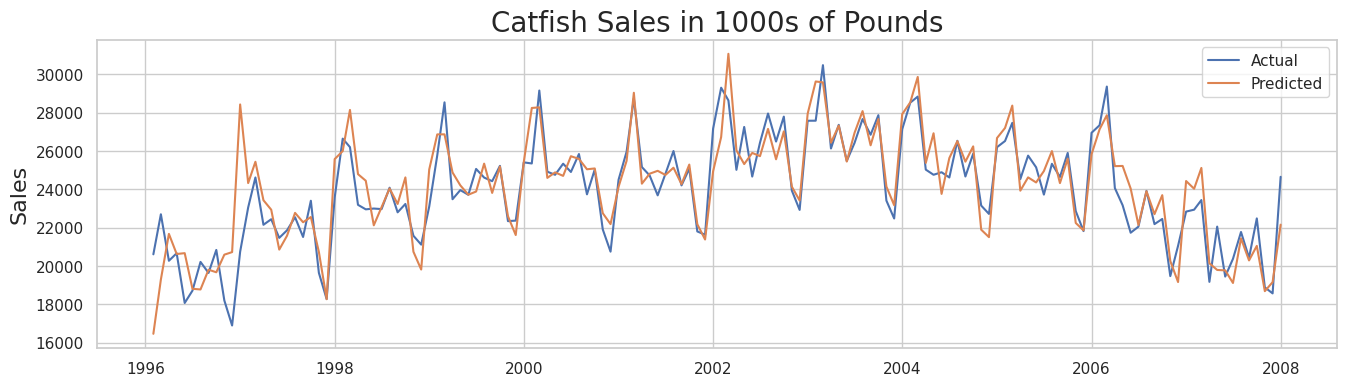

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(df['Total'].iloc[1:], label="Actual")
plt.plot(predictions.iloc[1:], label="Predicted")
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend()

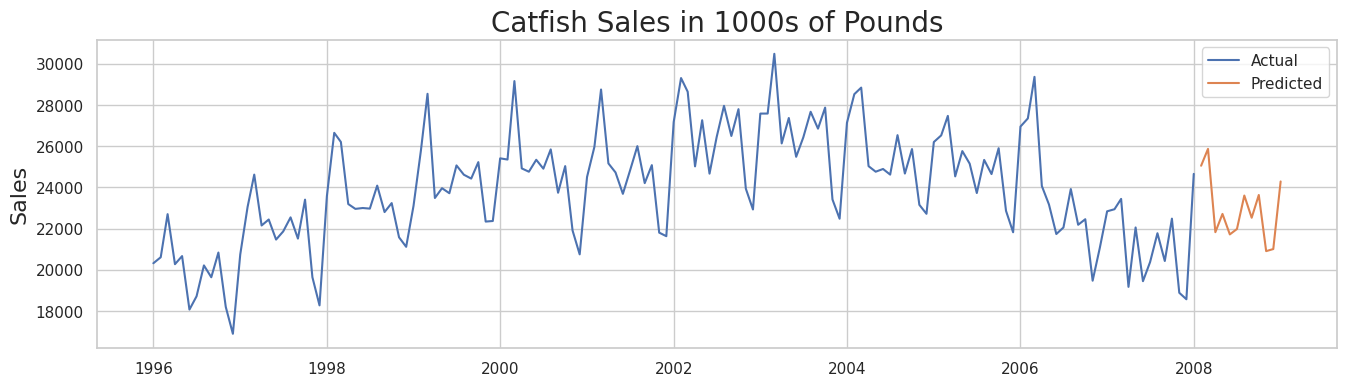

In [ ]:
y_forecast_sarima = model_fit.forecast(steps = 12)
plt.figure(figsize=(16,4))
plt.plot(df['Total'], label="Actual")
plt.plot(y_forecast_sarima, label="Predicted")
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend()

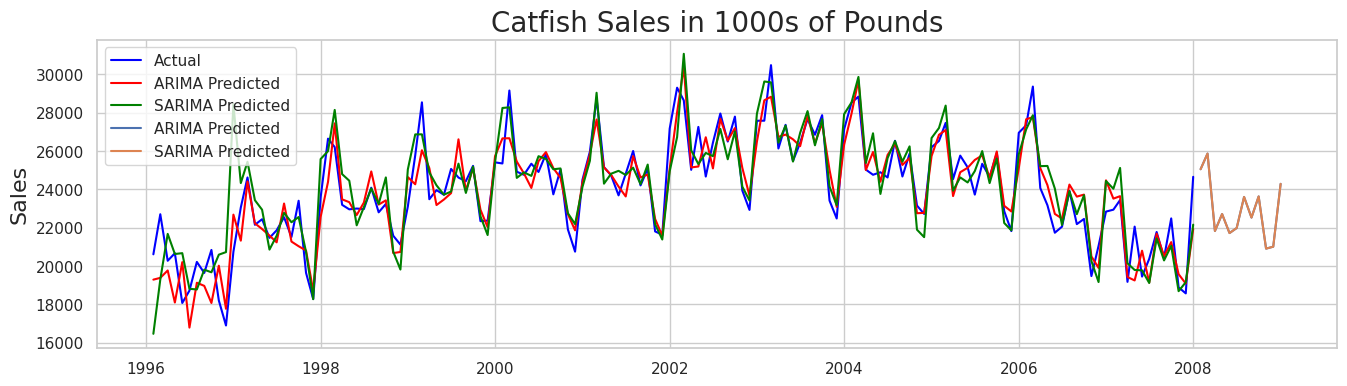

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(df['Total'].iloc[1:], label="Actual", color = 'blue')
plt.plot(y_pred.iloc[1:], label="ARIMA Predicted", color = 'red')
plt.plot(predictions.iloc[1:], label="SARIMA Predicted", color = 'green')
plt.plot(y_forecast_arima, label="ARIMA Predicted")
plt.plot(y_forecast_sarima, label="SARIMA Predicted")
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend()

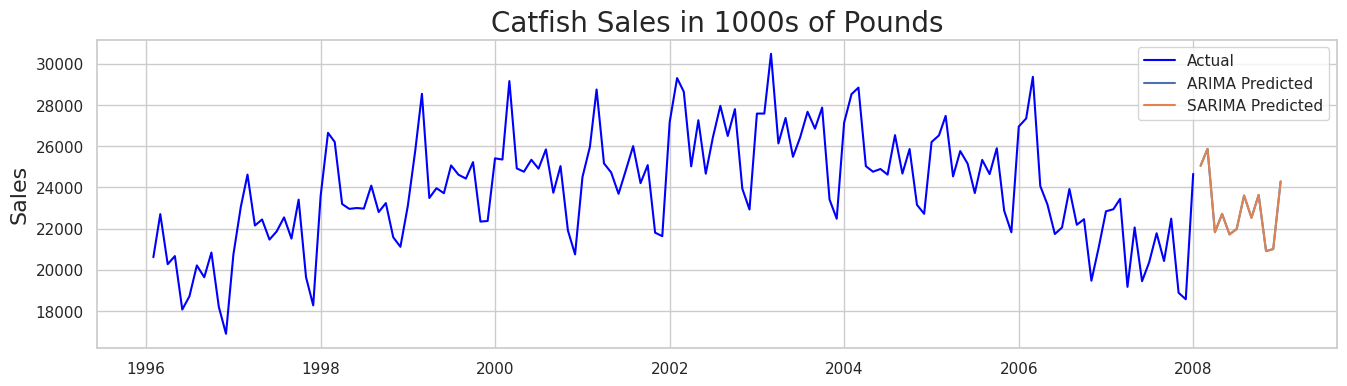

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(df['Total'].iloc[1:], label="Actual", color = 'blue')

plt.plot(y_forecast_arima, label="ARIMA Predicted")
plt.plot(y_forecast_sarima, label="SARIMA Predicted")
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend()